In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import json
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc('font', family='NanumGothicOTF')
plt.rcParams['axes.unicode_minus'] = False
# delete the cache
mpl.font_manager._rebuild()

# load the data

In [25]:
raw_data = pd.read_csv('ratings.txt', header=0, delimiter='\t', quoting=3)

In [26]:
train_data = pd.read_csv('ratings_train.txt', header=0, delimiter='\t', quoting=3)
train_data.tail(10)

,id,document,label
149990,6373651,이걸 영화라고 찎었냐?,0
149991,9492905,http://blog.naver.com/oroblast/220215679580 나쁜...,1
149992,9335962,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 5...,0
149993,10020916,For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.,1
149994,9458520,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요.,1
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [27]:
train_data.columns

Index(['id', 'document', 'label'], dtype='object')

In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
id          150000 non-null int64
document    149995 non-null object
label       150000 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [29]:
# 수치형 데이터 기술통계 id와 이진분류 label(0, 1)뿐이므로 의미는 없다.
train_data['document'].describe()

count     149995
unique    146182
top            굿
freq         181
Name: document, dtype: object

In [30]:
# 명목형 데이터 기술통계
train_data.describe(include=np.object)

,document
count,149995
unique,146182
top,굿
freq,181


In [31]:
# 리뷰당 길이
review_length = train_data['document'].astype(str).apply(len)
review_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

In [32]:
# 리뷰당 길이의 평균, 표준편차, 최솟값, 최댓값, 사분위수. (중앙값은 50%) 
review_length.describe()

count    150000.000000
mean         35.237493
std          29.582361
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         158.000000
Name: document, dtype: float64

In [33]:
# 리뷰당 단어 갯수
train_word_per_review = train_data['document'].astype(str).apply(lambda x: len(x.split(' ')))
train_word_per_review.head()

0     5
1     4
2     1
3     6
4    11
Name: document, dtype: int64

In [34]:
# 리뷰당 단어 갯수 기술통계
train_word_per_review.describe()

count    150000.000000
mean          7.584940
std           6.514063
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          41.000000
Name: document, dtype: float64

In [35]:
# 리뷰당 딘어의 평균, 표준편차, 최솟값, 최댓값, 사분위수. (중앙값은 50%) 
train_word_per_review.describe()

count    150000.000000
mean          7.584940
std           6.514063
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          41.000000
Name: document, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

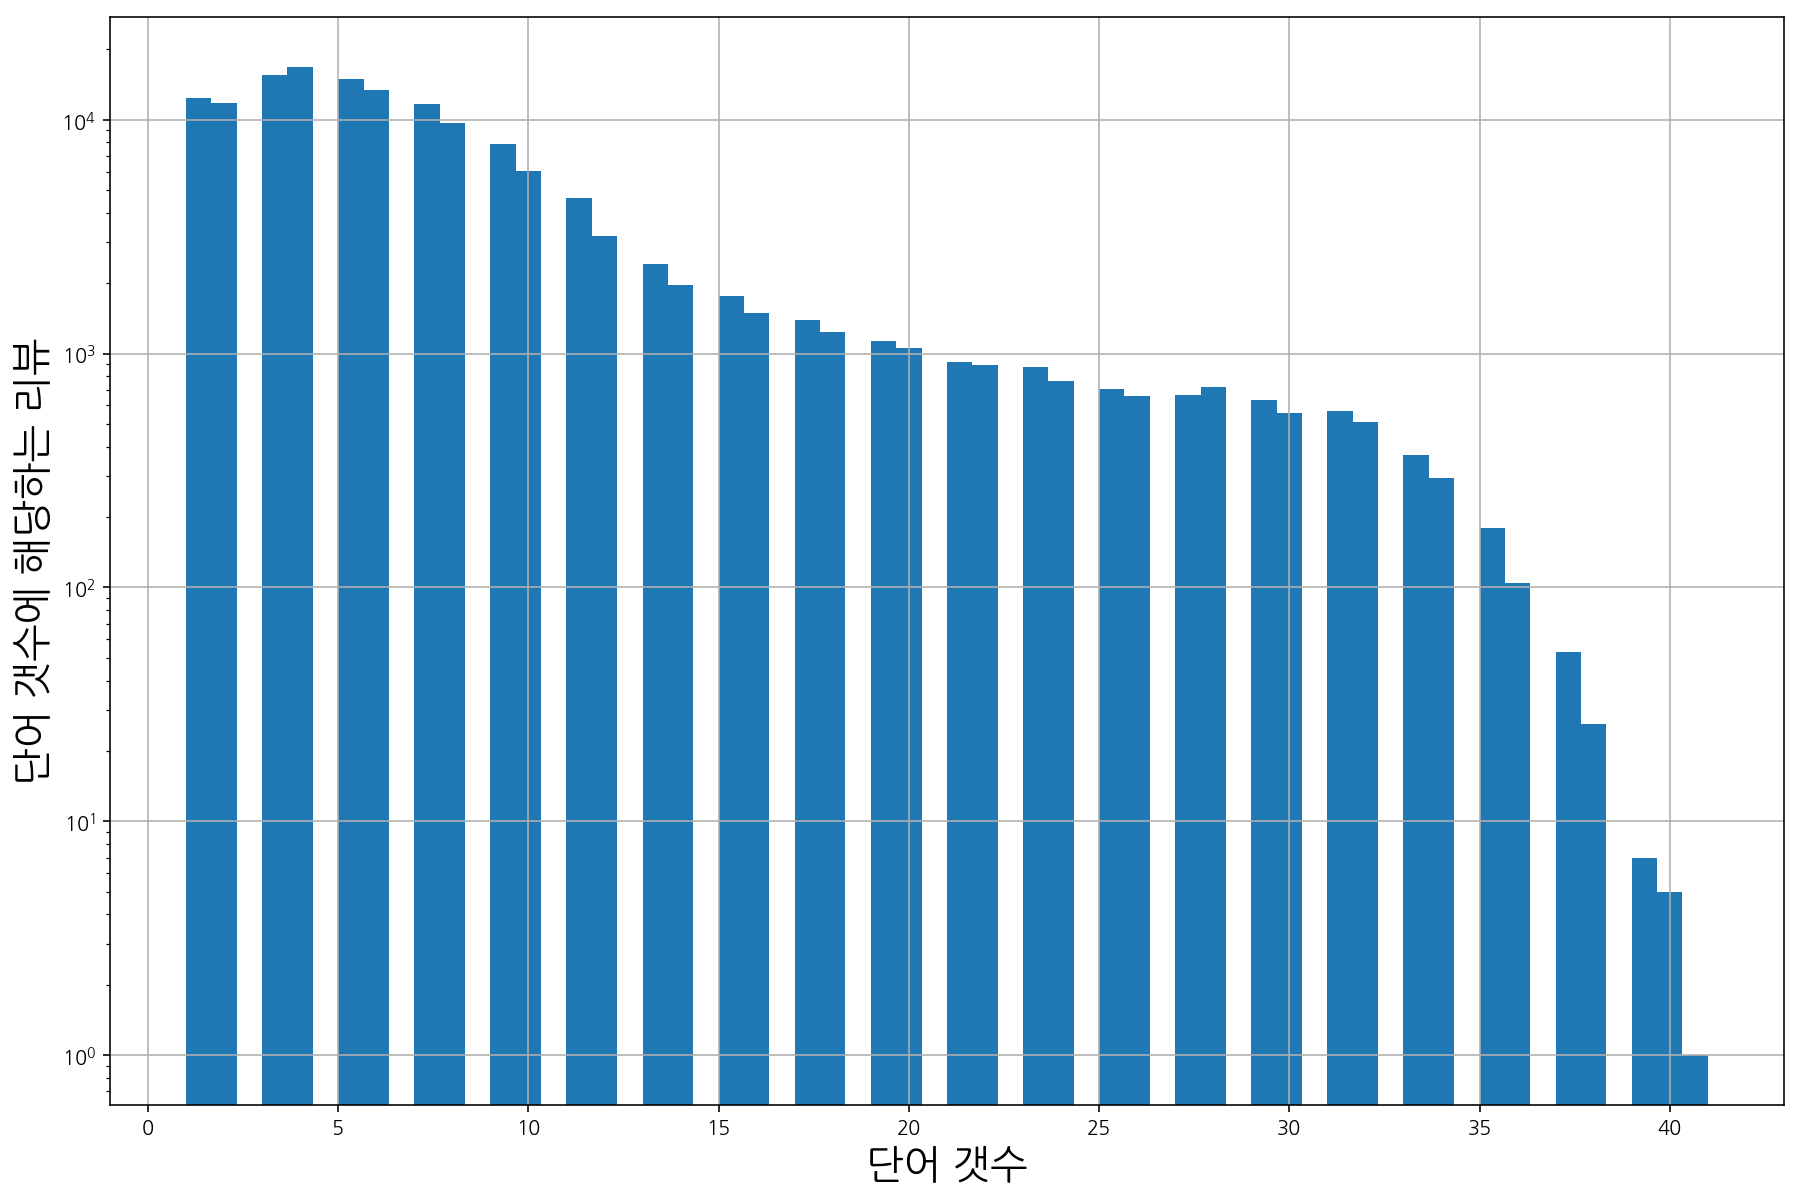

In [36]:
plt.figure(figsize=(15, 10))
train_word_per_review.hist(bins=60)
plt.yscale('log')
plt.xlabel('단어 갯수', fontsize=20)
plt.ylabel('단어 갯수에 해당하는 리뷰', fontsize=20)
plt.show

In [37]:
# 중복되는 ID는 없음
len(raw_data.id.unique())

200000

In [38]:
# 결측치 확인
train_data.isnull().sum()
# document에 5개의 결측치가 있음

id          0
document    5
label       0
dtype: int64

In [39]:
# document에 있는 5개의 결측치 삭제
train_data = train_data.dropna(subset=['document'])

In [40]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [41]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

# Preprocessing

In [42]:
okt = Okt()

In [43]:
def preprocessing(review, okt, remove_stopwords=False, stop_words=[]):
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    
    return word_review

In [44]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들', '의',
              '있', '되', '수', '보', '주', '등', '한']

In [45]:
clean_train_reviews = list()
for review in train_data['document']:
    clean_train_reviews.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))

In [46]:
print('리뷰 갯수: {}'.format(len(clean_train_reviews)))
clean_train_reviews[:5]

리뷰 갯수: 149995


[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '하다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [47]:
test_data = pd.read_csv('ratings_test.txt', header=0, delimiter='\t', quoting=3)
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [48]:
# test 데이터 결측치 삭제
test_data = test_data.dropna(subset=['document'])

In [49]:
# test 데이터 전처리
clean_test_reviews = list()
for review in test_data['document']:
    clean_test_reviews.append(preprocessing(review, okt, remove_stopwords=True,
                                            stop_words=stop_words))

In [50]:
clean_test_reviews[:5]

[['굳다', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['만',
  '아니다',
  '별',
  '다섯',
  '개',
  '주다',
  '왜',
  '로',
  '나오다',
  '제',
  '심기',
  '를',
  '불편하다',
  '하다']]

In [60]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
train_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
test_sequences = tokenizer.texts_to_sequences(clean_test_reviews)

word_vocab = tokenizer.word_index
MAX_SEQUENCE_LENGTH = 8

In [61]:
train_inputs = pad_sequences(train_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# 학습 데이터를 벡터화
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 평가 데이터를 벡터화
test_labels = np.array(test_data['label']) # 평가 데이터의 라벨

In [66]:
test_labels

array([1, 0, 0, ..., 0, 0, 0])

In [63]:
test_sequences

[[648, 93],
 [],
 [64, 169, 31, 436, 24, 25, 303, 886, 51, 789, 23],
 [73, 24, 92, 344, 115, 109, 67, 154, 281],
 [18, 23, 129, 2225, 108, 67, 41, 22, 29, 199, 13779, 7, 805, 3],
 [215, 2926, 16, 32, 215, 1],
 [660, 71],
 [1017, 381, 328, 26, 4217, 7301, 8, 1433, 4091, 2097, 4962, 7, 3624, 3],
 [517,
  1183,
  16,
  2652,
  212,
  63,
  8,
  3077,
  669,
  203,
  48,
  6,
  104,
  2218,
  4,
  212,
  392,
  15314,
  19,
  1,
  89,
  371,
  2264,
  9],
 [2656, 1386, 496, 4, 3078, 543, 3024, 3929, 233, 45, 78, 24],
 [136, 348, 18, 7394, 20237, 396, 60],
 [201, 1118, 1130, 509, 697, 16, 608, 16],
 [1046,
  151,
  34,
  151,
  250,
  5989,
  5,
  2637,
  418,
  9172,
  151,
  250,
  5,
  69,
  15403,
  1452,
  151,
  10328,
  19,
  3663,
  1,
  9],
 [240, 4, 244, 196, 9, 1, 9511, 370, 995, 24],
 [38,
  117,
  30,
  1352,
  1100,
  1,
  1338,
  969,
  104,
  1,
  4,
  159,
  739,
  5,
  432,
  47,
  1,
  241,
  20165,
  57,
  33,
  1,
  5945,
  374,
  119,
  31571,
  33,
  1,
  7,
  3811,
 

In [70]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

import os
os.makedirs(DATA_IN_PATH, exist_ok=True)

np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)